In [29]:
#!pip install gretel_synthetics

^C


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType, Normalization
print(pd.__version__)


2.0.3


In [2]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [3]:
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

In [4]:
index = [0,3] if MODEL==0 else [1,2]

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,index], base_data_test[:,:,index] # 0,3 = th vs air; 1,2 = el vs sky, 6 = month, 7 = winter/summer
print(base_data_train.shape, base_data_test.shape)

(108, 730, 2) (12, 730, 2)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


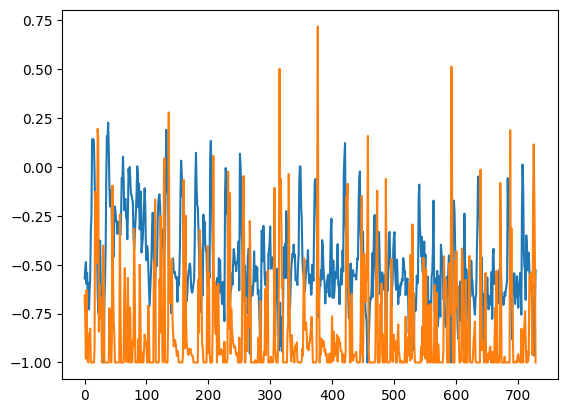

In [6]:
plt.plot(scaled_data_train[10])
plt.show()

In [7]:
attributes = np.random.randint(0, 1, size=(base_data_train.shape[0],1))
features = scaled_data_train.copy()

In [8]:
print(attributes.shape, features.shape)

(108, 1) (108, 730, 2)


In [9]:
type(attributes)

numpy.ndarray

In [10]:
# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [11]:
b_sizes = [2]#,4,6,8,10,12,16,20,24,32]
e_sizes = [10]#0, 1000]

model_samples = []
for e_size in e_sizes:
    for b_size in b_sizes:
        model = DGAN(DGANConfig(
            max_sequence_len=scaled_data_train.shape[1],
            sample_len=1,
            batch_size=b_size,
            epochs=e_size,  # For real data sets, 100-1000 epochs is typical
        ))
        
        model.train_numpy(
            attributes=attributes,
            attribute_types = [OutputType.DISCRETE] * 1,
            features=features,
            feature_types = [OutputType.CONTINUOUS] * 2,
        )
        
        # Generate synthetic data
        synthetic_attributes, synthetic_features = model.generate_numpy(1000)
        model_samples.append(synthetic_features)

2024-03-27 14:36:32,664 : MainThread : INFO : epoch: 0
C:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
2024-03-27 14:36:37,740 : MainThread : INFO : epoch: 1
2024-03-27 14:36:40,264 : MainThread : INFO : epoch: 2
2024-03-27 14:36:42,641 : MainThread : INFO : epoch: 3
2024-03-27 14:36:45,108 : MainThread : INFO : epoch: 4
2024-03-27 14:36:47,550 : MainThread : INFO : epoch: 5
2024-03-27 14:36:49,985 : MainThread : INFO : epoch: 6
2024-03-27 14:36:52,434 : MainThread : INFO : epoch: 7
2024-03-27 14:36:54,841 : MainThread : INFO : epoch: 8
2024-03-27 14:36:57,207 : MainThread : INFO : epoch: 9


In [ ]:
model.save('../../data

In [42]:
print(synthetic_attributes.shape, synthetic_features.shape)

(1000, 1) (1000, 730, 2)


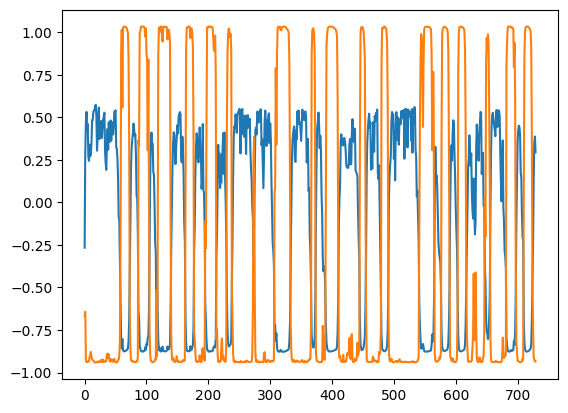

In [44]:
plt.plot(synthetic_features[10])

In [45]:
temp_var, energy_var = synthetic_features[:,:,0],  synthetic_features[:,:,1]
temp_var, energy_var = scalers['G.air.T'].inverse_transform(temp_var), scalers['G.E_th_I'].inverse_transform(energy_var)

synthetic_features_rescaled = np.stack((temp_var, energy_var),axis=-1)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

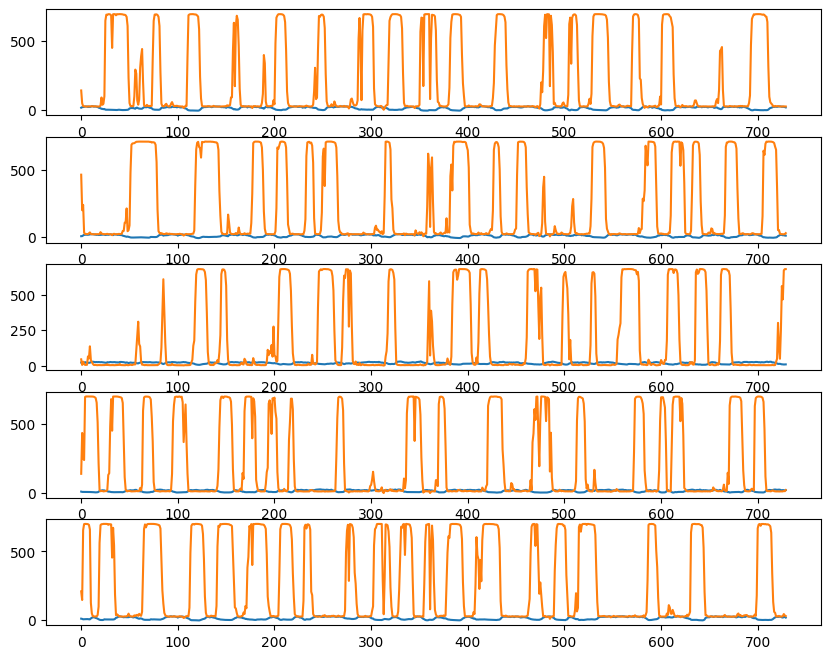

In [46]:
import random

fig, ax = plt.subplots(5,1, figsize=(10,8))

indices = random.sample(range(0,1000),5)
for i, sample in enumerate(indices):
    ax[i].plot(synthetic_features_rescaled[sample])

plt.plot    


In [47]:
np.save(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy', synthetic_features)
np.save(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy', synthetic_features_rescaled)